In [1]:
from itertools import chain,cycle
import os

from tqdm import trange
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image



import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

/home/sabuhi_khalili/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**References**:
The model design and loss functions are prepared based on the original DiscoGAN implementation:https://github.com/SKTBrain/DiscoGAN
I added weight initializer using this Discogan implementation: https://github.com/carpedm20/DiscoGAN-pytorch
Both implementations are designed early versions of python and torch, but this code is running in latest versions

**Brief description of the problem and data**:

The task is to create monet style photos using a GANs model. I am using below DiscoGAN and compare it with CycleGAN implementation.


We understand that the dataset contains four directories, including monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories have the same painting images, while the photo_tfrec and photo_jpg directories have the same photos.

To train our model, we should use the images in the monet directories, which contain Monet paintings. We also need to add Monet-style to the photos in the photo directories and submit the generated jpeg images as a zip file. We will limit the submissions to the photos provided in photos folder.

It's worth noting that Monet-style art can be created from scratch using other GAN architectures, such as DCGAN. Therefore, the image files we submit do not necessarily have to be transformed photos.

In [2]:
sns.set(style="white")
random_seed = 123

**Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

This task requires no cleaning of data as well as no fixing the labels since there are none. We could maybe check if some of monet pictures are by accident in photos folder, but I don't beleive that is the case.

In [3]:
GCS_PATH = os.getcwd()

MONET_FILENAMES = [os.path.join(GCS_PATH, 'monet_jpg', file) for file in os.listdir(os.path.join(GCS_PATH, 'monet_jpg')) if file.endswith('.jpg')]
print('Monet JPG Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = [os.path.join(GCS_PATH, 'photo_jpg', file) for file in os.listdir(os.path.join(GCS_PATH, 'photo_jpg')) if file.endswith('.jpg')]
print('Photo JPG Files:', len(PHOTO_FILENAMES))

Monet JPG Files: 300
Photo JPG Files: 7038


There overall 300 Monet photos and 7038 regular photos. It could very well improve the performance if we had Monet photos, but one shoul not expect a painter to draw that thousands of masterpieces in their entire life. 

The only data processing we need is to load image data to numeric arrays and standardize them. I am loading the images with RGB channels and divide them by max value (255) to standardize them between 0 and 1. Some standardize between -1 and 1 and use Leaky Relu, but for me it is a bit pointless since the 0 and 255 are the theoretical boundaries of image arrays and shifting it to negative axis just to use Leaky Relu makes no sense. I also tranpose the image arrays and put channels to the first dimension as tensor models expect it to be in the first dimension. 

In [4]:
def decode_image(image):
    image = Image.open(image).convert('RGB')
    image = np.array(image)
    image = image.astype('float32') / 255
    return image

def load_dataset(filenames):
    images = []
    for filename in filenames:
        image = decode_image(filename).transpose(2, 0, 1) # Transpose to NCHW format
        images.append(torch.from_numpy(image).float())
    dataset = torch.utils.data.TensorDataset(torch.stack(images))
    return dataset


In [5]:
monet_ds = load_dataset(MONET_FILENAMES)
photo_ds = load_dataset(PHOTO_FILENAMES)

In [6]:
# dataset loader
batch_size = 16
shuffle = True

A_train_loader = DataLoader(
    monet_ds, batch_size=batch_size, shuffle=shuffle, drop_last=True)

B_train_loader = DataLoader(
    photo_ds, batch_size=batch_size, shuffle=shuffle, drop_last=True)


We may see below that there are less colors in monet photos than input photos. This will become very important later when we transfer monet style to input photos, you will notice that some of the colors have changed. I beleive this might be mainly because of the variety of the colors in monet photos which our model will understand as its distinct style. 

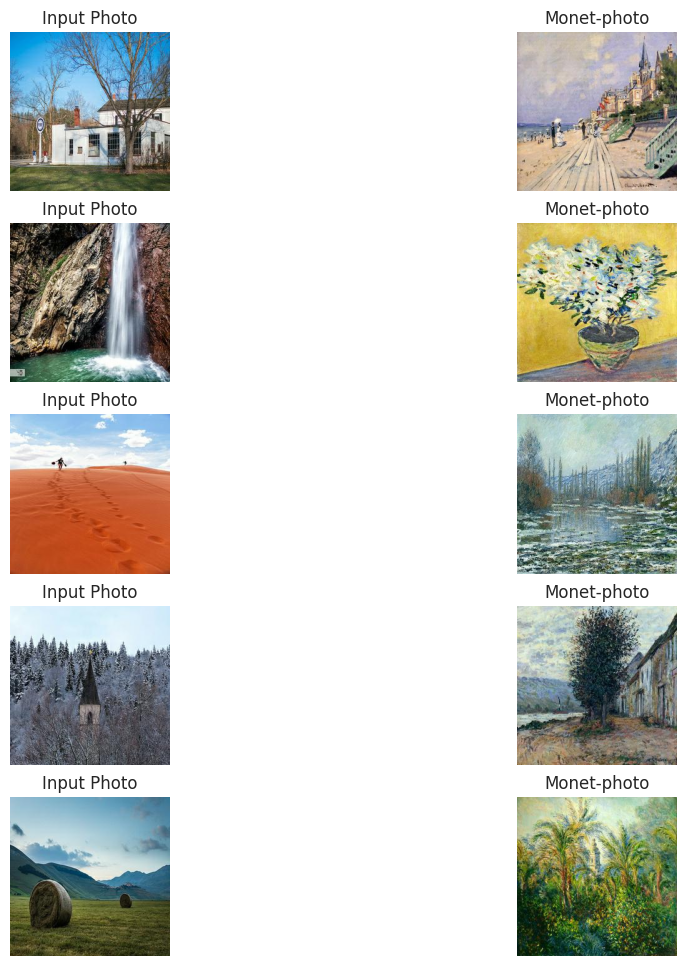

In [7]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i in range(5):
    img_photo = photo_ds[i][0].numpy()
    img_monet = monet_ds[i][0].numpy()

    img_photo = img_photo.transpose(1,2,0)
    img_monet = img_monet.transpose(1,2,0)

    ax[i, 0].imshow(img_photo)
    ax[i, 1].imshow(img_monet)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

**Model Architecture**

The model below is an implementation of DiscoGAN. The detailed description is given at each section

This is the implementation of the Generator in the DiscoGAN architecture, which is responsible for generating new images from input images.

The first part of the network is composed of several convolutional layers, which reduce the spatial dimensions of the input while increasing the number of channels. The second part of the network is composed of several transposed convolutional layers, which increase the spatial dimensions of the tensor while reducing the number of channels.

The final layer of the network is a sigmoid activation function, which scales the pixel values to the range [0,1].

In [8]:
class Generator(nn.Module):
    def __init__(
            self,
            ):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64 * 2,     64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,      3, 4, 2, 1, bias=False),
            nn.Sigmoid()
            )

    def forward(self, input):
        return self.main( input )

This code defines the discriminator model in the DiscoGAN architecture. The discriminator is responsible for distinguishing between real and generated images. 

The discriminator is composed of several convolutional layers, each followed by batch normalization and an activation function. The activation function used in the first four layers is the Rectified Linear Unit (ReLU), and the activation function used in the final layer is the sigmoid function. The forward method defines the forward pass of the discriminator. The input image is passed through the convolutional layers, and the output is a scalar value representing the probability that the input image is real.

The forward method also returns the intermediate feature maps obtained after the second, third, and fourth convolutional layers. These feature maps are used as input to the generator and reconstruction discriminators in the DiscoGAN architecture.

In [9]:
class Discriminator(nn.Module):
    def __init__(
            self,
            ):

        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 2)
        self.relu2 = nn.ReLU( inplace=True)

        self.conv3 = nn.Conv2d(64 * 2,  1, 4, 1, 0, bias=False)

    def forward(self, input):
        conv1 = self.conv1( input )
        relu1 = self.relu1( conv1 )

        conv2 = self.conv2( relu1 )
        bn2 = self.bn2( conv2 )
        relu2 = self.relu2( bn2 )

        conv3 = self.conv3( relu2 )

        return torch.sigmoid( conv3 ), [relu2]

get_fm_loss is a helper function that computes the feature matching loss between the real and generated features. The function takes the real and fake features as input, along with a criterion (HingeEmbeddingLoss) to compute the loss. The function iterates over the real and fake features, and computes the L2 distance between their means. The mean L2 distance is then passed to the criterion to compute the feature matching loss. The losses for all the feature maps are accumulated and returned.

In [10]:
def get_fm_loss(real_feats, fake_feats, criterion):
    losses = 0
    for real_feat, fake_feat in zip(real_feats, fake_feats):
        l2 = (real_feat.mean(0) - fake_feat.mean(0)) * (real_feat.mean(0) - fake_feat.mean(0))
        loss = criterion(l2, Variable( torch.ones(l2.size() ) ).cuda())
        losses += loss

    return losses

The get_gan_loss function computes the adversarial loss for the model by comparing the output of a discriminator with the expected labels (i.e., real or fake) for both real and fake data samples. The criterion is binary cross entropy.

In [11]:
def get_gan_loss(dis_real, dis_fake, criterion):
    labels_dis_real = Variable(torch.ones( dis_real.size()))
    labels_dis_fake = Variable(torch.zeros(dis_fake.size()))
    labels_gen = Variable(torch.ones(dis_fake.size()))

    labels_dis_real = labels_dis_real.cuda()
    labels_dis_fake = labels_dis_fake.cuda()
    labels_gen = labels_gen.cuda()

    dis_loss = criterion( dis_real, labels_dis_real ) * 0.5 + criterion( dis_fake, labels_dis_fake ) * 0.5
    gen_loss = criterion( dis_fake, labels_gen )

    return dis_loss, gen_loss

Define below separate generator for A and B. A in our context is monet, B is photo

In [12]:
generator_A = Generator()
generator_B = Generator()
discriminator_A = Discriminator()
discriminator_B = Discriminator()

If we use an odd kernel size, for example 3, in convolutional transpose, we need to additional set output_padding, otherwise, dimensions won't match. 

In [13]:
print(generator_A)
print(discriminator_A)

Generator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)
Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


 The objective of weights initializer is to improve the efficiency and accuracy of the training process by making the network converge faster and reduce the risk of overfitting.

In the code provided, the weights_init function is used to initialize the weights of the generator and discriminator models. The function uses a normal distribution with mean 0 and standard deviation 0.02 to initialize the weights of the convolutional layers, while the weights of the batch normalization layers are initialized to 1 with a standard deviation of 0.02, and the biases are initialized to 0.

This type of initialization has been found to work well for deep convolutional neural networks used in image processing tasks, such as those used in this code for image-to-image translation with CycleGAN. Initializing the weights in this way helps to prevent vanishing gradients and exploding gradients, which can cause problems during training.

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
generator_A.apply(weights_init)
generator_B.apply(weights_init)

discriminator_A.apply(weights_init)
discriminator_B.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

Pass everything to  NVIDIA Cuda.

In [15]:
generator_A = generator_A.cuda()
generator_B = generator_B.cuda()
discriminator_A = discriminator_A.cuda()
discriminator_B = discriminator_B.cuda()

In [16]:
recon_criterion = nn.MSELoss()
gan_criterion = nn.BCELoss()
feat_criterion = nn.HingeEmbeddingLoss()

Optimizer is set to ADAM as usual, no additional parameters

In [17]:
gen_params = chain(generator_A.parameters(), generator_B.parameters())
dis_params = chain(discriminator_A.parameters(), discriminator_B.parameters())

optim_gen = torch.optim.Adam( gen_params)
optim_dis = torch.optim.Adam( dis_params)

I try with 1000, but it will be increased to 5000 in Kaggle submission. I am also using the weights used by original DiscoGAN paper, but one can play around given the time and machine availability.

In [18]:
max_iteration = 10000
recon_loss_weight = 0.5
fm_loss_weight = 0.9

A_loader, B_loader = cycle(iter(A_train_loader)), cycle(iter(B_train_loader)) # create an infinite iterator over B_loader

The model and training is mostly similiar to Cycle GAN, but the major distionction is coming from loss functions.

  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------
GEN Loss:0.6440, 0.7511
Feature Matching Loss:0.1818, 0.1802
RECON Loss::0.0635, 0.0808
DIS Loss::0.7355, 0.7843


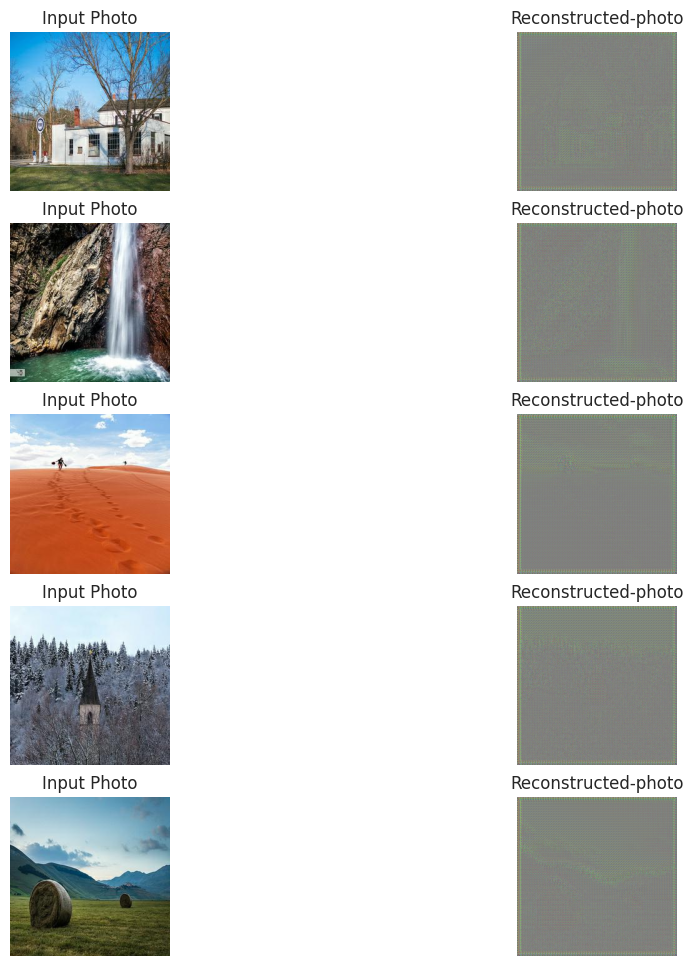

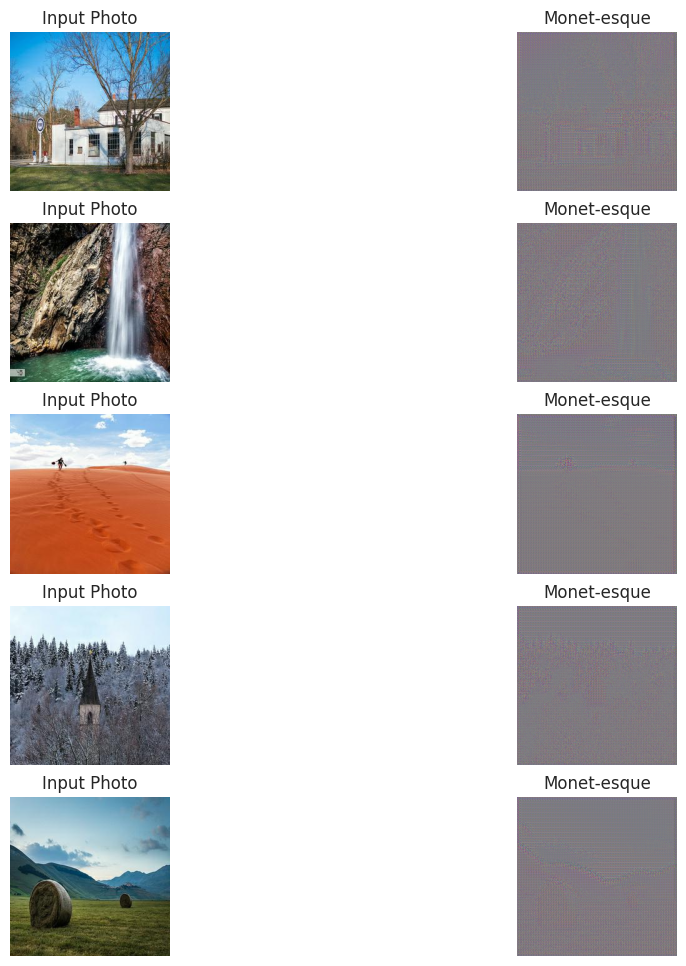

 25%|██▌       | 2500/10000 [12:13<39:30,  3.16it/s]

---------------------
GEN Loss:0.6521, 0.7220
Feature Matching Loss:0.0206, 0.0237
RECON Loss::0.0067, 0.0060
DIS Loss::0.6969, 0.6966


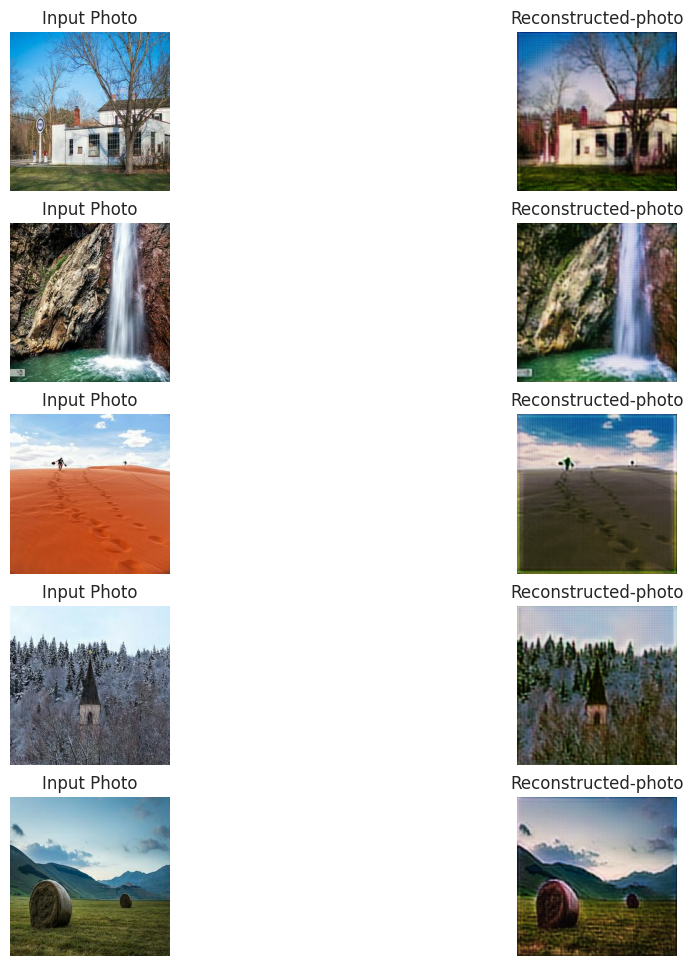

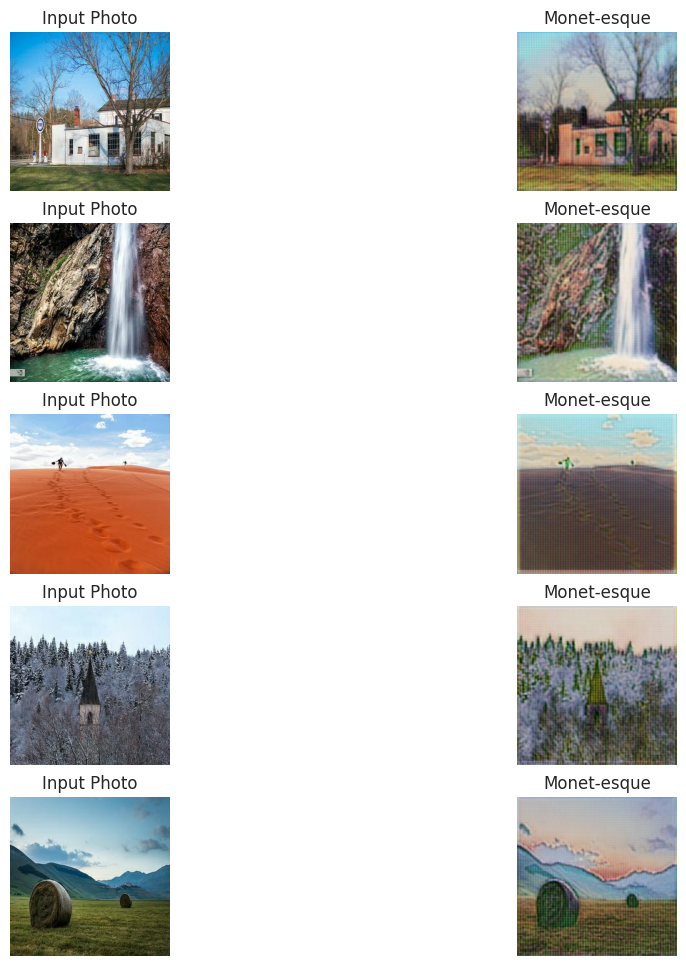

 50%|█████     | 5000/10000 [24:58<25:12,  3.30it/s]  

---------------------
GEN Loss:0.6911, 0.7095
Feature Matching Loss:0.0162, 0.0240
RECON Loss::0.0046, 0.0052
DIS Loss::0.6885, 0.6924


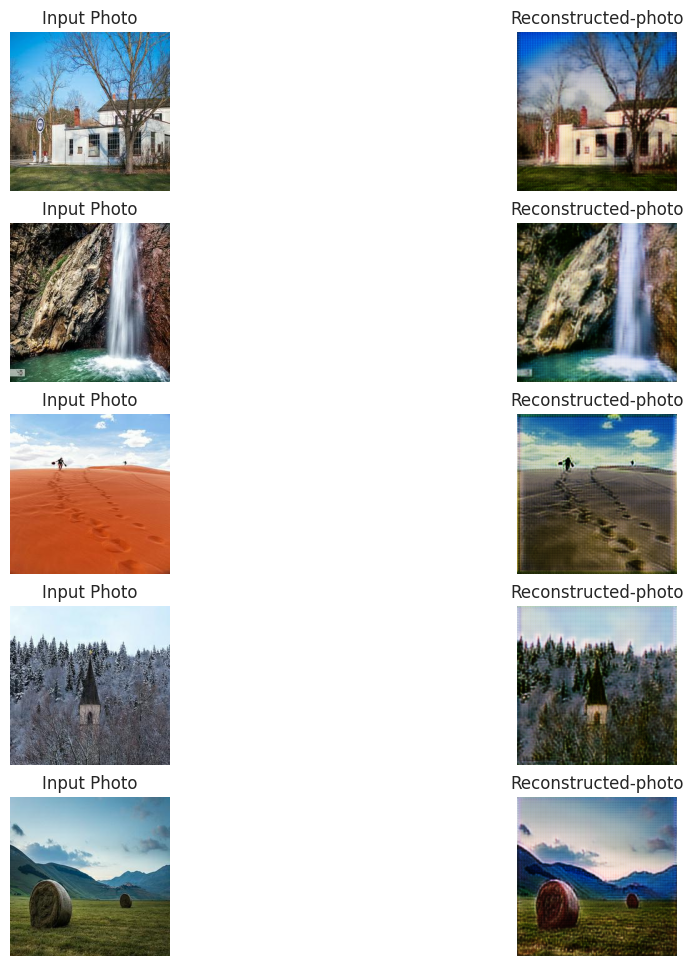

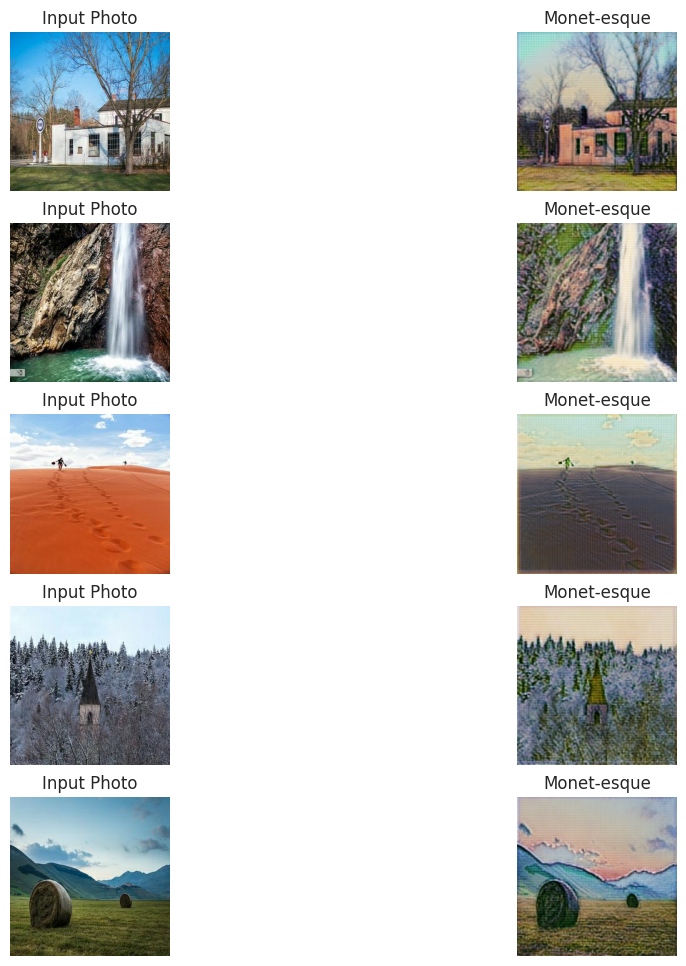

 75%|███████▌  | 7500/10000 [38:08<13:34,  3.07it/s]

---------------------
GEN Loss:0.6943, 0.6941
Feature Matching Loss:0.0181, 0.0222
RECON Loss::0.0077, 0.0047
DIS Loss::0.6905, 0.6932


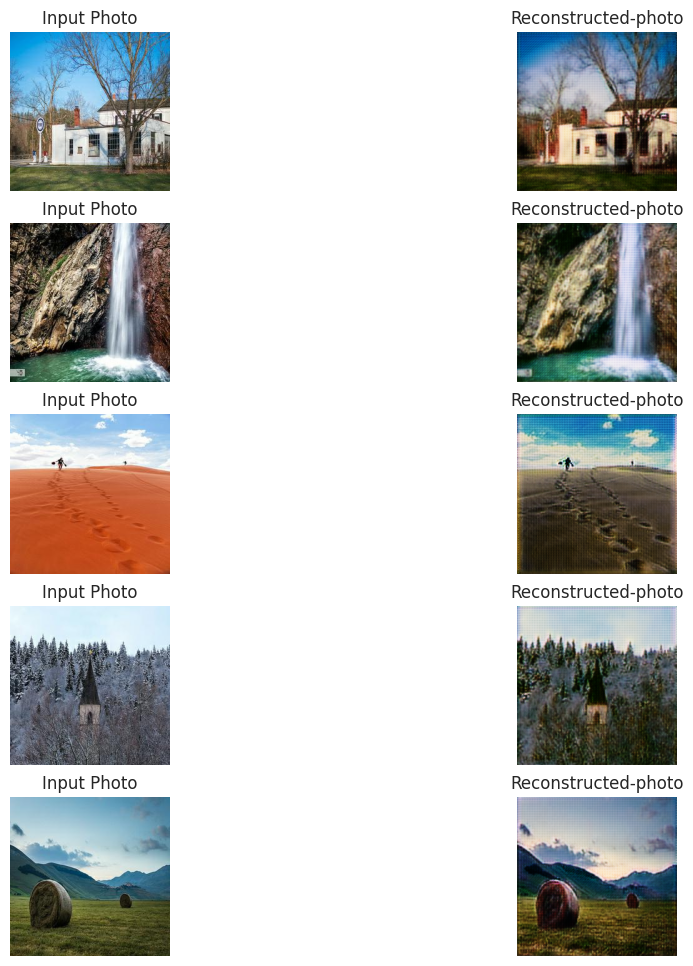

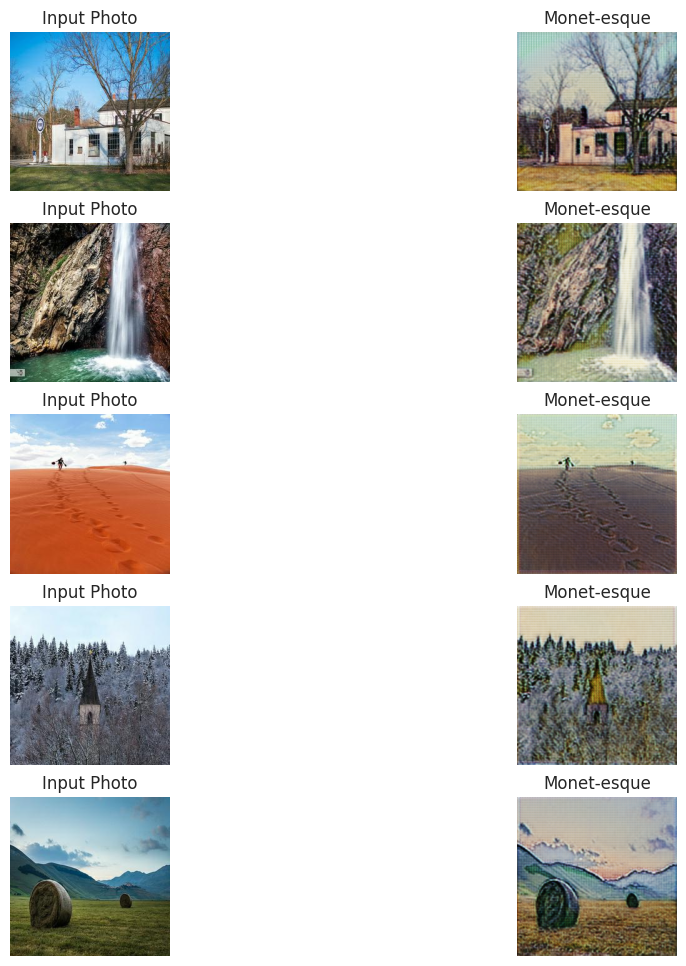

100%|██████████| 10000/10000 [52:00<00:00,  3.20it/s]


In [19]:
gen_loss_hist = []
dis_loss_hist = []
for idx in trange(max_iteration):
    x_A, x_B = A_loader.__next__()[0], B_loader.__next__()[0]
    

    A = Variable( torch.FloatTensor( x_A ) )
    B = Variable( torch.FloatTensor( x_B ) )

    A = A.cuda()
    B = B.cuda()

    # x_A, x_B = Variable(x_A.cuda()), Variable(x_B.cuda())
    # batch_size = x_A.size(0)

    generator_A.zero_grad()
    generator_B.zero_grad()
    discriminator_A.zero_grad()
    discriminator_B.zero_grad()


    AB = generator_B(A)    
    BA = generator_A(B)
    ABA = generator_A(AB) 
    BAB = generator_B(BA) 

    # Reconstruction Loss
    recon_loss_A = recon_criterion( ABA, A )
    recon_loss_B = recon_criterion( BAB, B )

    # Real/Fake GAN Loss (A)
    A_dis_real, A_feats_real = discriminator_A( A )
    A_dis_fake, A_feats_fake = discriminator_A( BA )

    dis_loss_A, gen_loss_A = get_gan_loss(A_dis_real, A_dis_fake, gan_criterion)
    fm_loss_A = get_fm_loss(A_feats_real, A_feats_fake, feat_criterion)

    # Real/Fake GAN Loss (B)
    B_dis_real, B_feats_real = discriminator_B( B )
    B_dis_fake, B_feats_fake = discriminator_B( AB )

    dis_loss_B, gen_loss_B = get_gan_loss(B_dis_real, B_dis_fake, gan_criterion)
    fm_loss_B = get_fm_loss(B_feats_real, B_feats_fake, feat_criterion)

    # Total Loss

    rate = 0.5

    gen_loss_A_total = (gen_loss_B*(1-fm_loss_weight) + fm_loss_B*fm_loss_weight) * (1-recon_loss_weight) + recon_loss_A * recon_loss_weight
    gen_loss_B_total = (gen_loss_A*(1-fm_loss_weight) + fm_loss_A*fm_loss_weight) * (1-recon_loss_weight) + recon_loss_B * recon_loss_weight

    gen_loss = gen_loss_A_total + gen_loss_B_total
    dis_loss = dis_loss_A + dis_loss_B

    # this is done so that dis_loss and gen_loss are updating weights in different iterations since they are using at least the one of channels at the same time
    if idx % 2 == 0:
        dis_loss.backward()
        optim_dis.step()
    else:
        gen_loss.backward()
        optim_gen.step()

    gen_loss_hist.append(float(gen_loss.mean()))
    dis_loss_hist.append(float(dis_loss.mean()))


    if float(idx)/max_iteration*100  % 25 == 0:

            print("---------------------")
            print("GEN Loss:{:.4f}, {:.4f}".format(float(gen_loss_A.mean()), float(gen_loss_B.mean())))
            print("Feature Matching Loss:{:.4f}, {:.4f}".format(float(fm_loss_A.mean()), float(fm_loss_B.mean())))
            print ("RECON Loss::{:.4f}, {:.4f}".format(float(recon_loss_A.mean()), float(recon_loss_B.mean())))
            print ("DIS Loss::{:.4f}, {:.4f}".format(float(dis_loss_A.mean()), float(dis_loss_B.mean())))
            # print("[{}/{}] Loss_D: {:.4f} Loss_G: {:.4f}".format(idx, max_iteration, l_d.item(), l_g.item()))
            
            _, ax = plt.subplots(5, 2, figsize=(12, 12))
            for i, img in enumerate(photo_ds):
                
                img = img[0].unsqueeze(0)
                _img = Variable(img.cuda())
                
                x_BA = generator_A(_img).detach()
                prediction = generator_B(x_BA).detach().cpu()

                img = img[0].permute(1, 2,0).numpy()
                prediction = prediction[0].permute(1, 2, 0).numpy()

                img = (img * 255).astype(np.uint8)
                prediction = (prediction * 255).astype(np.uint8)

                ax[i, 0].imshow(img)
                ax[i, 1].imshow(prediction)
                ax[i, 0].set_title("Input Photo")
                ax[i, 1].set_title("Reconstructed-photo")
                ax[i, 0].axis("off")
                ax[i, 1].axis("off")
                if i==4:
                    break
            plt.show()

            _, ax = plt.subplots(5, 2, figsize=(12, 12))
            for i, img in enumerate(photo_ds):
                
                img = img[0].unsqueeze(0)
                _img = Variable(img.cuda())
                
                prediction = generator_A(_img).detach().cpu()

                img = img[0].permute(1, 2,0).numpy()
                prediction = prediction[0].permute(1, 2, 0).numpy()

                img = (img * 255).astype(np.uint8)
                prediction = (prediction * 255).astype(np.uint8)

                ax[i, 0].imshow(img)
                ax[i, 1].imshow(prediction)
                ax[i, 0].set_title("Input Photo")
                ax[i, 1].set_title("Monet-esque")
                ax[i, 0].axis("off")
                ax[i, 1].axis("off")
                if i==4:
                    break
            plt.show()


**Results and Analysis**

In [20]:
def plot_metrics(gen_loss_hist, dis_loss_hist):
    iters = range(1, len(gen_loss_hist) + 1)

    plt.plot(iters, gen_loss_hist, '--b', label='Total Generative Loss')
    plt.plot(iters, dis_loss_hist, '--r', label='Total Discriminative Loss')
    plt.title('Total Loss')
    plt.legend()

    plt.show()

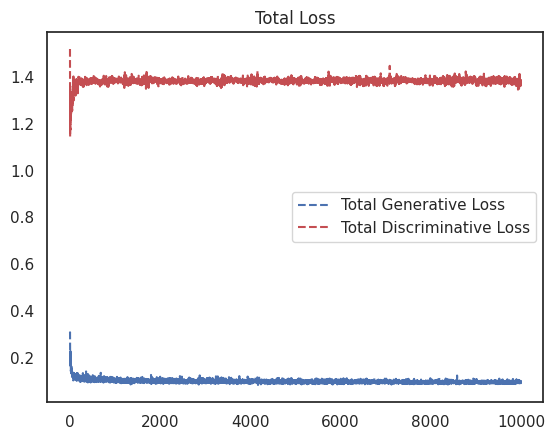

In [21]:
plot_metrics(gen_loss_hist=gen_loss_hist, dis_loss_hist=dis_loss_hist)

In [22]:
import PIL
if not os.path.isdir(os.path.join(GCS_PATH, 'images')):
    os.mkdir(os.path.join(GCS_PATH, 'images'))

for i, img in enumerate(photo_ds):
    img = img[0].unsqueeze(0)
    _img = Variable(img.cuda())

    prediction = generator_A(_img).detach().cpu()

    prediction = prediction[0].permute(1, 2, 0).numpy()
    prediction = (prediction * 255).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    filename = PHOTO_FILENAMES[i].split('/')[-1]
    im.save(os.path.join(GCS_PATH, "images/" + filename))
    i += 1

In [23]:
import shutil
shutil.make_archive(GCS_PATH + '/images', 'zip', os.path.join(GCS_PATH, "images/"))

'/home/sabuhi_khalili/autoenc/first_paper/side_proj/monet_gan/images.zip'